In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install db-dtypes\n")

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import datetime,itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install db-dtypes\n")

In [6]:
get_ipython().system('pip install pmdarima --quiet')
import pmdarima as pm

- DEFINE YOUR CLASSES AND FUNCTIONS 
-----------------------------------
This is not required, but is helpful in keeping your notebook organized. 
You can use the following cell or several cells to define your functions
and classes to keep them separate from your analysis or results code.
In general it useful to define your methods in a separate cell from where
it is run.

In [7]:
def example_function():
    print('Hello World')

In [8]:
def print_column_info(df):
    print(f'No. of columns: {len(df.columns)}')
    for col in df.columns:
        print(len(df[col].unique()),col,df[col].dtypes)
    print()

In [9]:
def print_na_info(df):
    for col in df.columns:
        print(df[col].isnull().sum(),col,df[col].dtypes)

In [10]:
def get_datetime(week_no):
    date = datetime.datetime.strptime("2022-"+str(week_no)+"-1","%Y-%W-%w")
    #print(date)
    return pd.to_datetime(date,format="%Y-%m-%d")

In [11]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=100, freq='D',disp=False):
    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            #try:
            mod = SARIMAX(ts,order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit(maxiter=maxiter,disp=False) 
            ans.append([comb, combs, output.bic])
            #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            #except:
            #    continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [12]:
def check_stationary(data,Print=0):
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                            "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

    critical_value = adft[4]['5%']
    if Print==1:
        print(output_df)
    if adft[1] < 0.05 and adft[0] < critical_value:
        return 1
    else:
        return 0

In [13]:
def diff_inv(series, last_observation):

    series_undifferenced = series.copy()

    series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation

    series_undifferenced = series_undifferenced.cumsum()

    return series_undifferenced

In [14]:
def loss(pred,actual):
    pred = np.round(pred)
    errors = abs(actual-pred)
    print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')
    print(f'Mean squared Error: {round(np.mean(errors**2), 2)}')
    mape = 100 * (errors/actual)
    # Calcualte and display accuracy
    accuracy = 100 - np.mean(mape)
    print(f'Accuracy: {round(accuracy, 2)}%.')

BIGQuery

In [15]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [16]:
#query = """
#SELECT 
#week_number,
#cases 
#FROM `ironhacks-data.ironhacks_training.covid19_cases`
#Where week_number between 1 and 3
#order by week_number
#"""
print("Datasets available:")
for dataset in list(bigquery_client.list_datasets()):
    print(dataset.dataset_id)
    if dataset.dataset_id == "ironhacks_competition":
        mydataset = dataset

Datasets available:


analytics
ironhacks_competition
ironhacks_training


In [17]:
print("\nTables available:")
for table in bigquery_client.list_tables("ironhacks_competition"):
    print(table.table_id)


Tables available:
prediction_list
unemployment_data
wage_data


In [18]:
query1 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""
query2 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [19]:
query3 = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [20]:
query_job1 = bigquery_client.query(query1)
query_job2 = bigquery_client.query(query2)
query_job3 = bigquery_client.query(query3)

In [21]:
prediction_data = query_job1.to_dataframe()
unemployment_data = query_job2.to_dataframe()
wage_data = query_job3.to_dataframe()

In [22]:
##Dumping the df to csv
week = "week2"
prediction_data.to_csv("prediction_data_"+week+".csv",index=False)
unemployment_data.to_csv("unemployment_data_"+week+".csv",index=False)
wage_data.to_csv("wage_data_"+week+".csv",index=False)

In [23]:
merged_data = pd.merge(unemployment_data,wage_data[["uu_id","average_wage"]],on="uu_id",how="left")
merged_data = merged_data.drop_duplicates()

In [24]:
query4 = """
SELECT table_id,
DATE(TIMESTAMP_MILLIS(creation_time)) AS creation_date,
DATE(TIMESTAMP_MILLIS(last_modified_time)) AS last_modified_date,
row_count,
size_bytes,
CASE
    WHEN type = 1 THEN 'table'
    WHEN type = 2 THEN 'view'
    WHEN type = 3 THEN 'external'
    ELSE '?'
END AS type,
TIMESTAMP_MILLIS(creation_time) AS creation_time,
TIMESTAMP_MILLIS(last_modified_time) AS last_modified_time,
dataset_id,
project_id
FROM `ironhacks-data.ironhacks_competition.__TABLES__`"""
query_job4 = bigquery_client.query(query4)
timestamp_data = query_job4.to_dataframe()
for cnt,row in timestamp_data.iterrows():
    print("\n")
    print(row["table_id"])
    print(row["creation_time"])
    print(row["last_modified_time"])



prediction_list
2022-11-29 17:00:10.722000+00:00
2022-11-29 17:00:10.723000+00:00


unemployment_data
2022-11-29 17:00:14.588000+00:00
2022-11-29 17:00:14.589000+00:00


wage_data
2022-11-29 17:00:10.578000+00:00
2022-11-29 17:00:10.579000+00:00


In [25]:
##Printing (unique_vals, col name, datatype)
print(f'\nunemployment_data : No. of columns = {len(unemployment_data.columns)},Max week number: {max(unemployment_data["week_number"])},Min week number: {min(unemployment_data["week_number"])}')
print_column_info(unemployment_data)
print(f'\nwage_data : No. of columns = {len(wage_data.columns)}')
print_column_info(wage_data)
print(f'\nprediction_data : No. of columns = {len(prediction_data.columns)},Max week number: {max(prediction_data["week_number"])},Min week number: {min(prediction_data["week_number"])}')
print_column_info(prediction_data)


unemployment_data : No. of columns = 25,Max week number: 37,Min week number: 1
No. of columns: 25
525 uu_id object
35 timeperiod Int64
35 week_number Int64
60 countyfips Int64
425 tract Int64
525 tract_name object
120 total_claims Int64
18 edu_8th_or_less Int64
40 edu_grades_9_11 Int64
95 edu_hs_grad_equiv Int64
68 edu_post_hs Int64
26 edu_unknown Int64
21 top_category_employer1 object
22 top_category_employer2 object
22 top_category_employer3 object
81 gender_female Int64
80 gender_male Int64
5 gender_na Int64
9 race_amerindian Int64
12 race_asian Int64
98 race_black Int64
31 race_noanswer Int64
2 race_hawaiiannative Int64
34 race_other Int64
76 race_white Int64


wage_data : No. of columns = 5
No. of columns: 5
525 uu_id object
60 countyfips Int64
425 tract Int64
525 tract_name object
525 average_wage float64


prediction_data : No. of columns = 2,Max week number: 44,Min week number: 44
No. of columns: 2
525 uu_id object
1 week_number Int64



In [26]:
count = 0
for uuid in unemployment_data["uu_id"].unique():
    if len(wage_data.loc[wage_data["uu_id"]==uuid])==0:
        count+=1
        #print(f'UUID {uuid} found in unemployment_data but not in wage_data')
print(f'{count} UUIDs found in unemployment_data but not in wage_data')
count = 0
for uuid in wage_data["uu_id"].unique():
    if len(unemployment_data.loc[unemployment_data["uu_id"]==uuid])==0:
        count+=1
        #print(f'UUID {uuid} found in unemployment_data but not in wage_data')
print(f'{count} UUIDs found in wage_data but not in unemployment_data')

0 UUIDs found in unemployment_data but not in wage_data


0 UUIDs found in wage_data but not in unemployment_data


In [27]:
count = 0
for uuid in unemployment_data["uu_id"].unique():
    if len(merged_data.loc[merged_data["uu_id"]==uuid])==0:
        count+=1
        #print(f'UUID {uuid} found in unemployment_data but not in wage_data')
print(f'{count} UUIDs found in unemployment_data but not in merged_data')

0 UUIDs found in unemployment_data but not in merged_data


In [28]:
count = 0
for uuid in merged_data["uu_id"].unique():
    if len(unemployment_data.loc[unemployment_data["uu_id"]==uuid])==0:
        count+=1
        #print(f'UUID {uuid} found in unemployment_data but not in wage_data')
print(f'{count} UUIDs found in merged_data but not in unemployment_data')

0 UUIDs found in merged_data but not in unemployment_data


In [29]:
##Merging average wage with unemployment data
print(f'unemployment_data: Unique uu_id = {len(unemployment_data["uu_id"].unique())}, Row count = {len(unemployment_data.index)}, Col count = {len(unemployment_data.columns)}')
print(f'wage_data: Unique uu_id = {len(wage_data["uu_id"].unique())}, Row count = {len(wage_data.index)}, Col count = {len(wage_data.columns)}')
#print(f'Unique uu_id in wage_data = {len(wage_data["uu_id"].unique())}')
print(f'\nunemployment_data: NaN info, Total rows={len(unemployment_data.index)}')
print_na_info(unemployment_data)
print(f'merged_data: Unique uu_id = {len(merged_data["uu_id"].unique())}, Row count = {len(merged_data.index)}, Col count = {len(merged_data.columns)}')

unemployment_data: Unique uu_id = 525, Row count = 16833, Col count = 25
wage_data: Unique uu_id = 525, Row count = 525, Col count = 5

unemployment_data: NaN info, Total rows=16833
0 uu_id object
0 timeperiod Int64
0 week_number Int64
0 countyfips Int64
0 tract Int64
0 tract_name object
0 total_claims Int64
3085 edu_8th_or_less Int64
10891 edu_grades_9_11 Int64
10797 edu_hs_grad_equiv Int64
13587 edu_post_hs Int64
4802 edu_unknown Int64
0 top_category_employer1 object
0 top_category_employer2 object
0 top_category_employer3 object
12998 gender_female Int64
12902 gender_male Int64
965 gender_na Int64
1548 race_amerindian Int64
1894 race_asian Int64
9709 race_black Int64
6744 race_noanswer Int64
407 race_hawaiiannative Int64
8758 race_other Int64
10441 race_white Int64
merged_data: Unique uu_id = 525, Row count = 13977, Col count = 26


In [30]:
print(f'\nmerged_data : No. of columns = {len(merged_data.columns)},Max week number: {max(merged_data["week_number"])},Min week number: {min(merged_data["week_number"])}')
print_column_info(merged_data)
print(f'\nmerged_data: NaN info, Total rows={len(merged_data.index)}')
print_na_info(merged_data)


merged_data : No. of columns = 26,Max week number: 37,Min week number: 1
No. of columns: 26
525 uu_id object
35 timeperiod Int64
35 week_number Int64
60 countyfips Int64
425 tract Int64
525 tract_name object
120 total_claims Int64
18 edu_8th_or_less Int64
40 edu_grades_9_11 Int64
95 edu_hs_grad_equiv Int64
68 edu_post_hs Int64
26 edu_unknown Int64
21 top_category_employer1 object
22 top_category_employer2 object
22 top_category_employer3 object
81 gender_female Int64
80 gender_male Int64
5 gender_na Int64
9 race_amerindian Int64
12 race_asian Int64
98 race_black Int64
31 race_noanswer Int64
2 race_hawaiiannative Int64
34 race_other Int64
76 race_white Int64
525 average_wage float64


merged_data: NaN info, Total rows=13977
0 uu_id object
0 timeperiod Int64
0 week_number Int64
0 countyfips Int64
0 tract Int64
0 tract_name object
0 total_claims Int64
2532 edu_8th_or_less Int64
9084 edu_grades_9_11 Int64
8895 edu_hs_grad_equiv Int64
11305 edu_post_hs Int64
3922 edu_unknown Int64
0 top_ca

In [31]:
#print(merged_data["week_number"])
merged_data["datetime"] = [get_datetime(val) for val in merged_data["week_number"]]
merged_data = merged_data.set_index(['datetime'])
merged_data = merged_data.sort_index()
merged_data.head(5)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [32]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import datetime,itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

- DEFINE YOUR CLASSES AND FUNCTIONS 
-----------------------------------
This is not required, but is helpful in keeping your notebook organized. 
You can use the following cell or several cells to define your functions
and classes to keep them separate from your analysis or results code.
In general it useful to define your methods in a separate cell from where
it is run.

In [33]:
def example_function():
    print('Hello World')

In [34]:
def print_column_info(df):
    print(f'No. of columns: {len(df.columns)}')
    for col in df.columns:
        print(len(df[col].unique()),col,df[col].dtypes)
    print()

In [35]:
def print_na_info(df):
    for col in df.columns:
        print(df[col].isnull().sum(),col,df[col].dtypes)

In [36]:
def get_datetime(week_no):
    date = datetime.datetime.strptime("2022-"+str(week_no)+"-1","%Y-%W-%w")
    #print(date)
    return pd.to_datetime(date,format="%Y-%m-%d")

In [37]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=100, freq='D',disp=False):
    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            #try:
            mod = SARIMAX(ts,order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit(maxiter=maxiter,disp=False) 
            ans.append([comb, combs, output.bic])
            #print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            #except:
            #    continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [38]:
def check_stationary(data,Print=0):
    adft = adfuller(data,autolag="AIC")
    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                            "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

    critical_value = adft[4]['5%']
    if Print==1:
        print(output_df)
    if adft[1] < 0.05 and adft[0] < critical_value:
        return 1
    else:
        return 0

In [39]:
def diff_inv(series, last_observation):

    series_undifferenced = series.copy()

    series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation

    series_undifferenced = series_undifferenced.cumsum()

    return series_undifferenced

In [40]:
def loss(pred,actual):
    pred = np.round(pred)
    errors = abs(actual-pred)
    print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')
    print(f'Mean squared Error: {round(np.mean(errors**2), 2)}')
    mape = 100 * (errors/actual)
    # Calcualte and display accuracy
    accuracy = 100 - np.mean(mape)
    print(f'Accuracy: {round(accuracy, 2)}%.')

In [41]:
#print(merged_data["week_number"])
merged_data["datetime"] = [get_datetime(val) for val in merged_data["week_number"]]
merged_data = merged_data.set_index(['datetime'])
merged_data = merged_data.sort_index()
merged_data.head(5)

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03,6c316cb2fc150a2f9fd50925926fc1f8,20220101,1,18127,50501,"Census Tract 505.01, Porter County, Indiana",49,0,<NA>,<NA>,...,34,0,0,0,<NA>,<NA>,0,17,25,8209.750000
2022-01-03,b57c8824284adeabf73b43cf206b3819,20220101,1,18093,951100,"Census Tract 9511, Lawrence County, Indiana",17,0,<NA>,10,...,<NA>,0,0,0,0,0,0,0,17,8991.250000
2022-01-03,f38aacf279329cbb0fd7807a9ddc6f6c,20220101,1,18097,350300,"Census Tract 3503, Marion County, Indiana",29,0,<NA>,19,...,<NA>,0,0,<NA>,22,<NA>,0,<NA>,<NA>,6736.181818
2022-01-03,44585653fcc97ff048845c7718889631,20220101,1,18067,1300,"Census Tract 13, Howard County, Indiana",12,0,<NA>,<NA>,...,<NA>,0,0,0,<NA>,<NA>,0,0,<NA>,6663.714286
2022-01-03,1400fd6122c6fe7582a30ee1280beb4b,20220101,1,18097,360602,"Census Tract 3606.02, Marion County, Indiana",16,0,0,11,...,<NA>,0,0,0,<NA>,0,0,0,<NA>,7009.000000


In [42]:
print(f'merged_data: Unique uu_id = {len(merged_data["uu_id"].unique())}, Row count = {len(merged_data.index)}, Col count = {len(merged_data.columns)}')

merged_data: Unique uu_id = 525, Row count = 13977, Col count = 26


In [43]:
print(f'\nmerged_data : No. of columns = {len(merged_data.columns)},Max week number: {max(merged_data["week_number"])},Min week number: {min(merged_data["week_number"])}')
print_column_info(merged_data)
print(f'\nmerged_data: NaN info, Total rows={len(merged_data.index)}')
print_na_info(merged_data)


merged_data : No. of columns = 26,Max week number: 37,Min week number: 1
No. of columns: 26
525 uu_id object
35 timeperiod Int64
35 week_number Int64
60 countyfips Int64
425 tract Int64
525 tract_name object
120 total_claims Int64
18 edu_8th_or_less Int64
40 edu_grades_9_11 Int64
95 edu_hs_grad_equiv Int64
68 edu_post_hs Int64
26 edu_unknown Int64
21 top_category_employer1 object
22 top_category_employer2 object
22 top_category_employer3 object
81 gender_female Int64
80 gender_male Int64
5 gender_na Int64
9 race_amerindian Int64
12 race_asian Int64
98 race_black Int64
31 race_noanswer Int64
2 race_hawaiiannative Int64
34 race_other Int64
76 race_white Int64
525 average_wage float64


merged_data: NaN info, Total rows=13977
0 uu_id object
0 timeperiod Int64
0 week_number Int64
0 countyfips Int64
0 tract Int64
0 tract_name object
0 total_claims Int64
2532 edu_8th_or_less Int64
9084 edu_grades_9_11 Int64
8895 edu_hs_grad_equiv Int64
11305 edu_post_hs Int64
3922 edu_unknown Int64
0 top_ca

In [44]:
entry_count = []
for uuid in merged_data["uu_id"].unique():
    entry_count.append([uuid,len(merged_data.loc[merged_data["uu_id"]==uuid])])
entry_count.sort(key=lambda x: x[1])
for entry in entry_count:
    print(f'uuid: {entry[0]}, weeks of data available: {entry[1]}')

uuid: f7f087af0599e6b2eaa4045ba1a0be50, weeks of data available: 3
uuid: 6fbb60a508283bc1fb30c13ac419941a, weeks of data available: 3
uuid: 747f8bc2b0c8c0a04d29caa4cfe327d2, weeks of data available: 4
uuid: b67c2c4abede3730932f8d53aba0341a, weeks of data available: 4
uuid: 99c1cb11273b064dc48649886138eb8e, weeks of data available: 5
uuid: b63efd0868b06138b7c8f9da9027e457, weeks of data available: 5
uuid: 676fffaaecefffe4ce93ca264c5c3c36, weeks of data available: 6
uuid: 3934b01a1e31d0a6af96867e1afbf03c, weeks of data available: 6
uuid: 001cd9ae23064d7f0fd3cd327c873d8d, weeks of data available: 6
uuid: b63901e116eff9653b0bb68135364147, weeks of data available: 7
uuid: 0aed17ab54d56c6651d331418e8db6be, weeks of data available: 7
uuid: f25446d4d951867ca7b984ad17c6c1e0, weeks of data available: 7
uuid: 248b6a72aba270fd9794b41f53813d5e, weeks of data available: 7
uuid: 420b44cc7e3f55d738df565421e59941, weeks of data available: 8
uuid: d6a4947ec7c2a78bd32ba4e30f3bba53, weeks of data availabl

In [45]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    #print(data_train)
    #SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(method="ffill"),
    #                       start_p=0, start_q=0,test="adf",
    #                       max_p=5, max_q=5,m=4,d=None,
    #                       trace=False,
    #                       suppress_warnings=True, 
    #                       maxiter=200,
    #                       stepwise=True,seasonal=True,D=None)
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,d=None,max_order=0)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

NameError: name 'sarimax_forecast' is not defined

In [46]:
def sarimax_forecast(SARIMAX_model, periods=10,plot=0):
    # Forecast
    n_periods = periods

    forecast_df = data[data.index>=data_train.index[-1]]
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True)
    #print(confint)
    index_of_fc = pd.date_range(data_train.index[-1], periods = n_periods, freq='W-MON')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    # Plot
    if plot:
        plt.figure(figsize=(15,7))
        plt.plot(data["total_claims"], color='#1f76b4')
        plt.plot(fitted_series, color='darkgreen')
        plt.fill_between(lower_series.index, 
                        lower_series, 
                        upper_series, 
                        color='k', alpha=.15)

        plt.title("SARIMAX")
        plt.show()
    return fitted_series

In [47]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,d=None,max_order=0)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34
1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34
eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34
1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34
3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34
2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
69274b987d26fbed84eb7d2b157badb6 36 5.875000000000002 19 -- 24
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33
f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34
3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25
074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27


48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34
97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34
3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34
939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 22.180185876976758 13 -- 34
8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34


6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34
fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34
931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34


32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34
4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 26.501209023219637 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34
15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31
46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34


89ca758dd8e4958d6e8e32ccb439c638 37 10.539376825254717 33 -- 33
4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31
7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34
94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34


348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34
e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34
0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34


50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34
447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34
8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34


abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33
25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34


4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34
d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34
b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 20.781293796632042 13 -- 34
52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34
63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34


2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34
953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 15.564752332829592 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34


f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34
663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34
50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34
f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 -9.528920646214395 16 -- 26


In [48]:
pred_df = pd.DataFrame()
uuid_list = []
week_number_list = []
total_claims_list = []
#stat=[]
for l in output:
    uuid_list.append(l[0])
    week_number_list.append(l[1])
    if l[2]<0:
        l[2] = 0
    total_claims_list.append(int(np.floor(l[2])))
    #stat.append(l[1])
pred_df["uu_id"] = uuid_list
pred_df["week_number"] = week_number_list
pred_df["total_claims"] = total_claims_list
#pred_df["stationarity"] = stat

In [49]:
pred = []
actual = []
pred_stat = []
actual_stat = []
pred_nonstat = []
actual_nonstat = []
ts_data = merged_data
for id,row in pred_df.iterrows():
    uuid = row["uu_id"]
    week_number = row["week_number"]
    if len(ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"])==0:
        continue
    actual_val = ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"].item()
    pred.append(row["total_claims"])
    actual.append(actual_val)

In [50]:
loss(pred=pred,actual=actual)        

Mean Absolute Error: 13.01
Mean squared Error: 377.94
Accuracy: 52.45%.


In [51]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,max_order=0)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34
1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34
0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34


eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34
1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34
b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34


3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34
5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34
2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
69274b987d26fbed84eb7d2b157badb6 36 5.875000000000002 19 -- 24
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33
f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34
3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25
074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27


48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34
97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34
3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34
939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 22.180185876976758 13 -- 34
8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34


6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34
fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34
931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34


32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34
4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 26.501209023219637 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34
15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31


46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34


89ca758dd8e4958d6e8e32ccb439c638 37 10.539376825254717 33 -- 33
4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31
7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34
94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34


348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34
e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34
0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34


50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34
447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34


8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34
abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33


25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34
4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34


d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34
b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 20.781293796632042 13 -- 34
52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34
63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34


2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34
953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 15.564752332829592 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34


f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34
663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34
50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34
f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 -9.528920646214395 16 -- 26


In [52]:
pred_df = pd.DataFrame()
uuid_list = []
week_number_list = []
total_claims_list = []
#stat=[]
for l in output:
    uuid_list.append(l[0])
    week_number_list.append(l[1])
    if l[2]<0:
        l[2] = 0
    total_claims_list.append(int(np.floor(l[2])))
    #stat.append(l[1])
pred_df["uu_id"] = uuid_list
pred_df["week_number"] = week_number_list
pred_df["total_claims"] = total_claims_list
#pred_df["stationarity"] = stat

In [53]:
pred = []
actual = []
pred_stat = []
actual_stat = []
pred_nonstat = []
actual_nonstat = []
ts_data = merged_data
for id,row in pred_df.iterrows():
    uuid = row["uu_id"]
    week_number = row["week_number"]
    if len(ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"])==0:
        continue
    actual_val = ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"].item()
    pred.append(row["total_claims"])
    actual.append(actual_val)

In [54]:
loss(pred=pred,actual=actual)        

Mean Absolute Error: 13.01
Mean squared Error: 377.94
Accuracy: 52.45%.


In [55]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,d=None)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34
1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34
eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34
1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34
3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34
2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
69274b987d26fbed84eb7d2b157badb6 36 5.875000000000002 19 -- 24
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33
f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34
3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25


074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27
48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34


97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34
3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34
939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 22.180185876976758 13 -- 34
8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34
6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31


9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34
fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34
931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34
32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34


4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 26.501209023219637 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34
15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31
46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34


89ca758dd8e4958d6e8e32ccb439c638 37 10.539376825254717 33 -- 33
4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31
7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34
94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34


348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34
e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34


0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34
50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34


447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34
8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34
abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33


25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34
4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34


d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34
b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 20.781293796632042 13 -- 34
52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34
63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34


2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34
953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 15.564752332829592 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34


f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34
663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34
50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34
f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 -9.528920646214395 16 -- 26


In [56]:
pred_df = pd.DataFrame()
uuid_list = []
week_number_list = []
total_claims_list = []
#stat=[]
for l in output:
    uuid_list.append(l[0])
    week_number_list.append(l[1])
    if l[2]<0:
        l[2] = 0
    total_claims_list.append(int(np.floor(l[2])))
    #stat.append(l[1])
pred_df["uu_id"] = uuid_list
pred_df["week_number"] = week_number_list
pred_df["total_claims"] = total_claims_list
#pred_df["stationarity"] = stat

In [57]:
pred = []
actual = []
pred_stat = []
actual_stat = []
pred_nonstat = []
actual_nonstat = []
ts_data = merged_data
for id,row in pred_df.iterrows():
    uuid = row["uu_id"]
    week_number = row["week_number"]
    if len(ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"])==0:
        continue
    actual_val = ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"].item()
    pred.append(row["total_claims"])
    actual.append(actual_val)

In [58]:
loss(pred=pred,actual=actual)        

Mean Absolute Error: 13.01
Mean squared Error: 377.94
Accuracy: 52.45%.


In [59]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,d=None,maxiter=200)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34
1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34
eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34
1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34
3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34
2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
69274b987d26fbed84eb7d2b157badb6 36 5.875000000000002 19 -- 24


4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33
f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34
3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25
074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27


48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34
97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34
3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34
939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 22.17069619413567 13 -- 34
8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34


6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34
fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34
931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34


32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34
4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 26.501209023219637 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34
15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31


46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34


89ca758dd8e4958d6e8e32ccb439c638 37 10.539376825254717 33 -- 33
4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31
7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34
94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34


348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34
e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34


0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34
50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34


447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34
8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34
abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33


25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34
4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34


d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34
b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 24.676470588235297 13 -- 34
52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34
63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34
2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34


953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 15.564752332829592 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34


f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34
663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34
50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34
f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 10.0 16 -- 26


In [60]:
ids = merged_data["uu_id"].unique()[:]
data = merged_data.loc[merged_data["uu_id"]==ids[500]].copy()
print(data["week_number"].max())
data_train = data[data["week_number"]<32]
data_train = data_train.asfreq('W-MON')

37


In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"])
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ValueError: cannot convert to 'float64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0))
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ValueError: x must have 2 complete cycles requires 104 observations. x only has 29 observation(s)

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=1)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

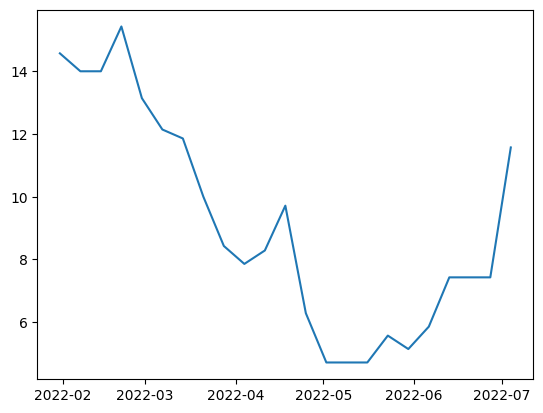

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.plot(trend)

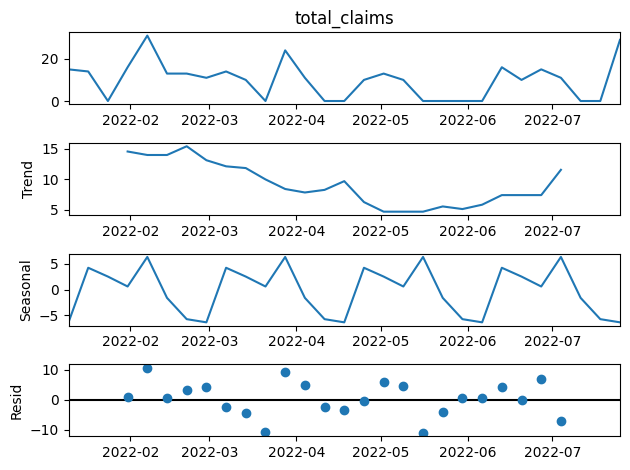

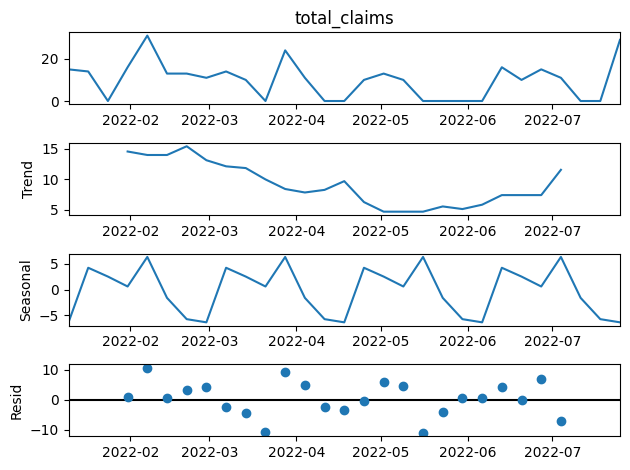

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

The time difference between the two minimums is 49 days 00:00:00


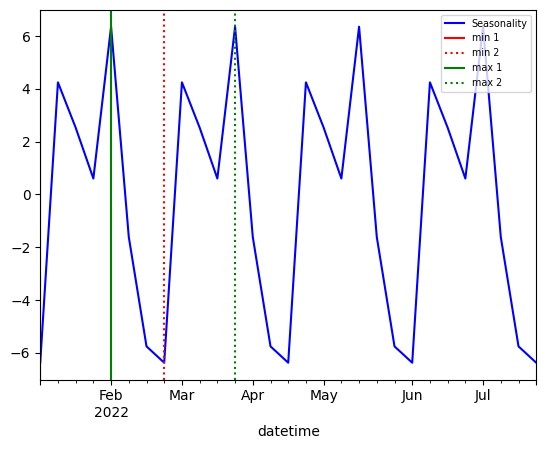

In [68]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

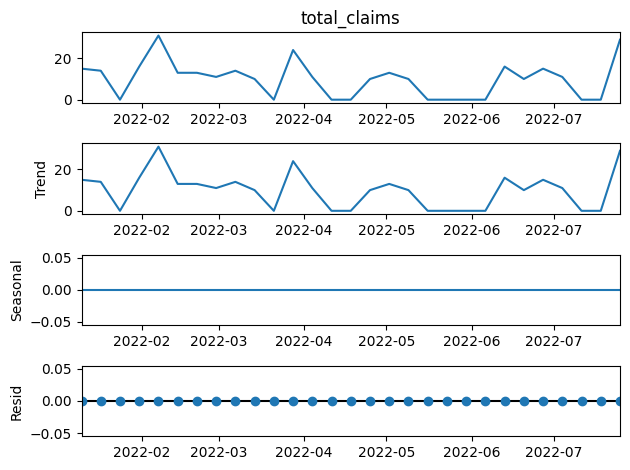

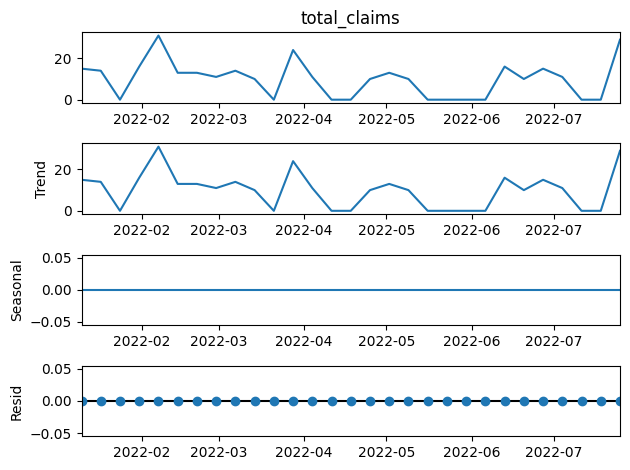

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=1)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

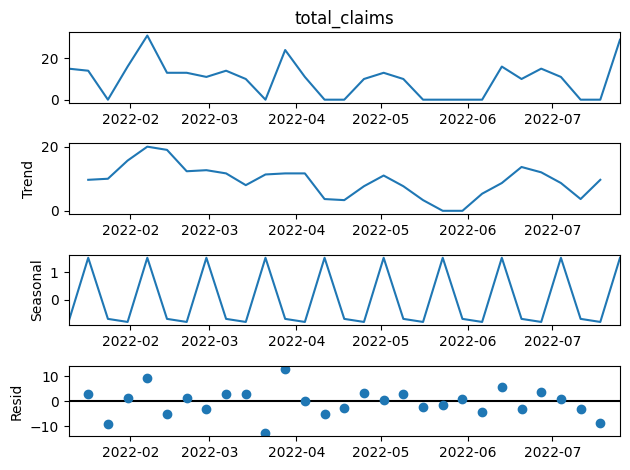

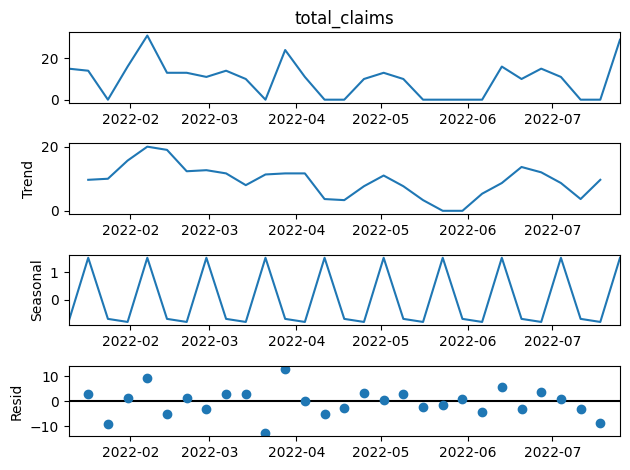

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=3)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

The time difference between the two minimums is 21 days 00:00:00


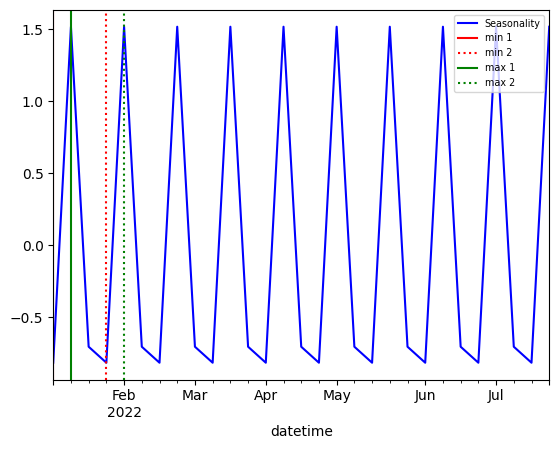

In [71]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0))
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

ValueError: x must have 2 complete cycles requires 104 observations. x only has 29 observation(s)

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=20)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

ValueError: x must have 2 complete cycles requires 40 observations. x only has 29 observation(s)

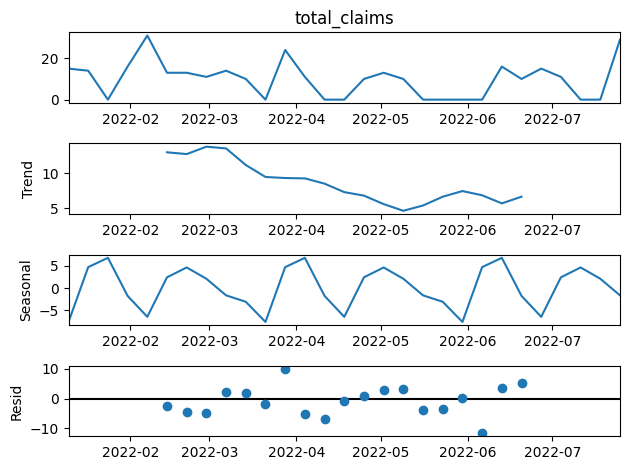

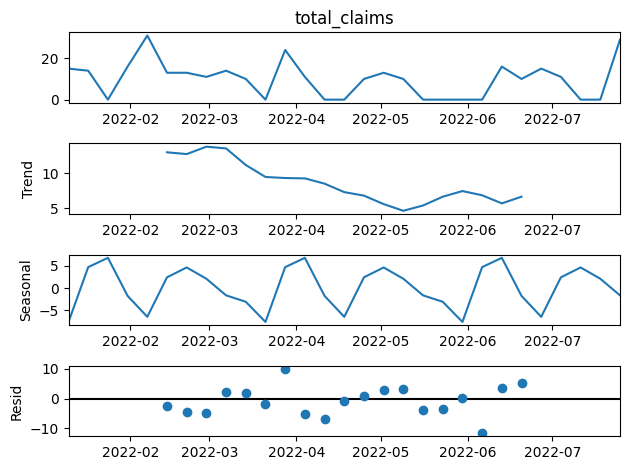

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=10)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()

The time difference between the two minimums is 70 days 00:00:00


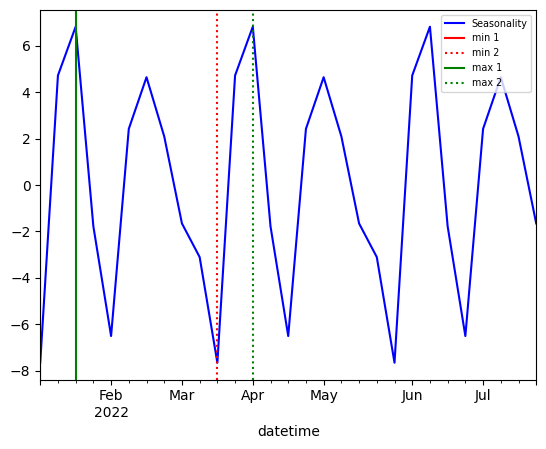

In [75]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

datetime
2022-01-10    15
2022-01-17    14
2022-01-24     0
2022-01-31    16
2022-02-07    31
2022-02-14    13
2022-02-21    13
2022-02-28    11
2022-03-07    14
2022-03-14    10
2022-03-21     0
2022-03-28    24
2022-04-04    11
2022-04-11     0
2022-04-18     0
2022-04-25    10
2022-05-02    13
2022-05-09    10
2022-05-16     0
2022-05-23     0
2022-05-30     0
2022-06-06     0
2022-06-13    16
2022-06-20    10
2022-06-27    15
2022-07-04    11
2022-07-11     0
2022-07-18     0
2022-07-25    29
Freq: W-MON, Name: total_claims, dtype: Int64


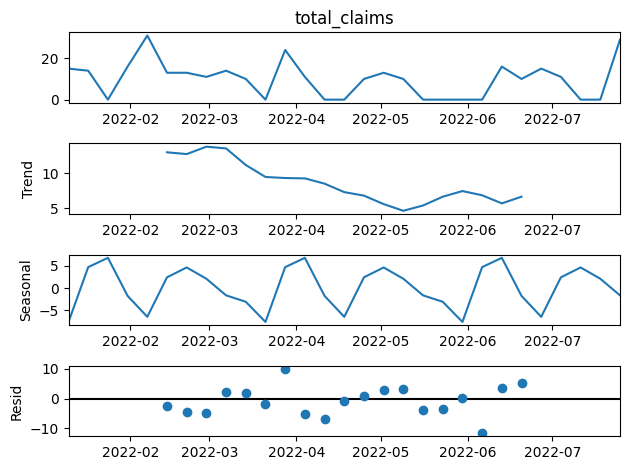

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=10)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

The time difference between the two minimums is 70 days 00:00:00


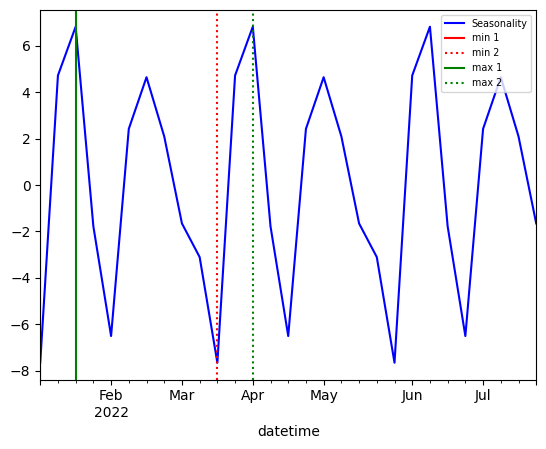

In [77]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=15)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

ValueError: x must have 2 complete cycles requires 30 observations. x only has 29 observation(s)

The time difference between the two minimums is 70 days 00:00:00


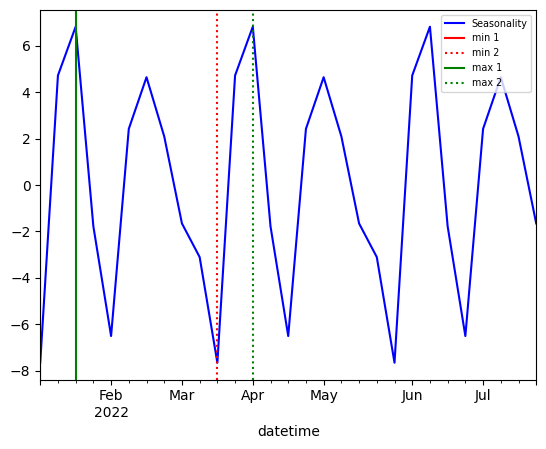

In [79]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

datetime
2022-01-10    15
2022-01-17    14
2022-01-24     0
2022-01-31    16
2022-02-07    31
2022-02-14    13
2022-02-21    13
2022-02-28    11
2022-03-07    14
2022-03-14    10
2022-03-21     0
2022-03-28    24
2022-04-04    11
2022-04-11     0
2022-04-18     0
2022-04-25    10
2022-05-02    13
2022-05-09    10
2022-05-16     0
2022-05-23     0
2022-05-30     0
2022-06-06     0
2022-06-13    16
2022-06-20    10
2022-06-27    15
2022-07-04    11
2022-07-11     0
2022-07-18     0
2022-07-25    29
Freq: W-MON, Name: total_claims, dtype: Int64


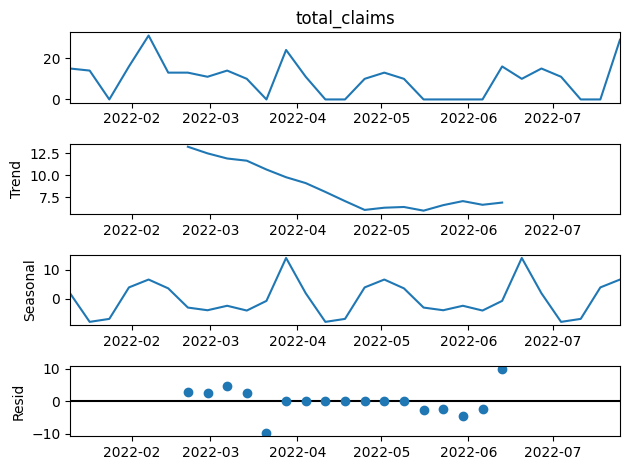

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=12)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

datetime
2022-01-10    15
2022-01-17    14
2022-01-24     0
2022-01-31    16
2022-02-07    31
2022-02-14    13
2022-02-21    13
2022-02-28    11
2022-03-07    14
2022-03-14    10
2022-03-21     0
2022-03-28    24
2022-04-04    11
2022-04-11     0
2022-04-18     0
2022-04-25    10
2022-05-02    13
2022-05-09    10
2022-05-16     0
2022-05-23     0
2022-05-30     0
2022-06-06     0
2022-06-13    16
2022-06-20    10
2022-06-27    15
2022-07-04    11
2022-07-11     0
2022-07-18     0
2022-07-25    29
Freq: W-MON, Name: total_claims, dtype: Int64


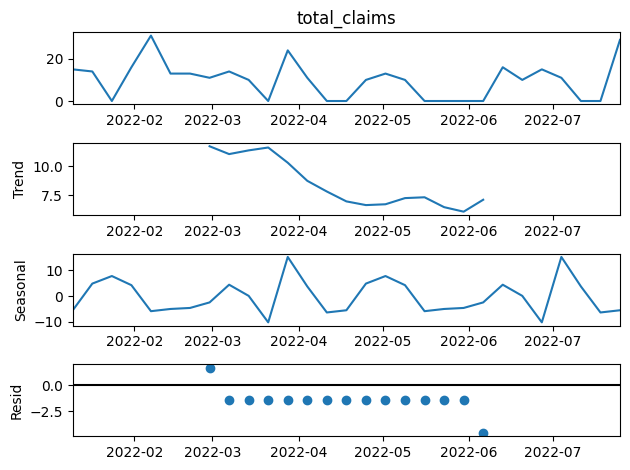

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

The time difference between the two minimums is 98 days 00:00:00


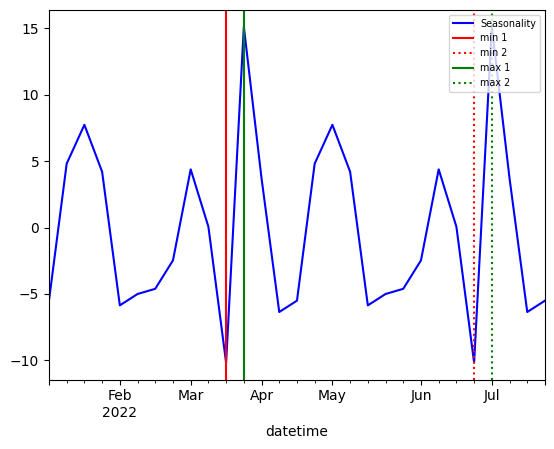

In [82]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=15)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

ValueError: x must have 2 complete cycles requires 30 observations. x only has 29 observation(s)

The time difference between the two minimums is 98 days 00:00:00


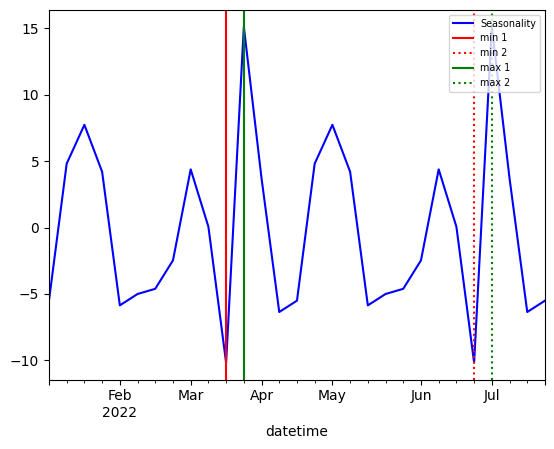

In [84]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

datetime
2022-01-10    15
2022-01-17    14
2022-01-24     0
2022-01-31    16
2022-02-07    31
2022-02-14    13
2022-02-21    13
2022-02-28    11
2022-03-07    14
2022-03-14    10
2022-03-21     0
2022-03-28    24
2022-04-04    11
2022-04-11     0
2022-04-18     0
2022-04-25    10
2022-05-02    13
2022-05-09    10
2022-05-16     0
2022-05-23     0
2022-05-30     0
2022-06-06     0
2022-06-13    16
2022-06-20    10
2022-06-27    15
2022-07-04    11
2022-07-11     0
2022-07-18     0
2022-07-25    29
Freq: W-MON, Name: total_claims, dtype: Int64


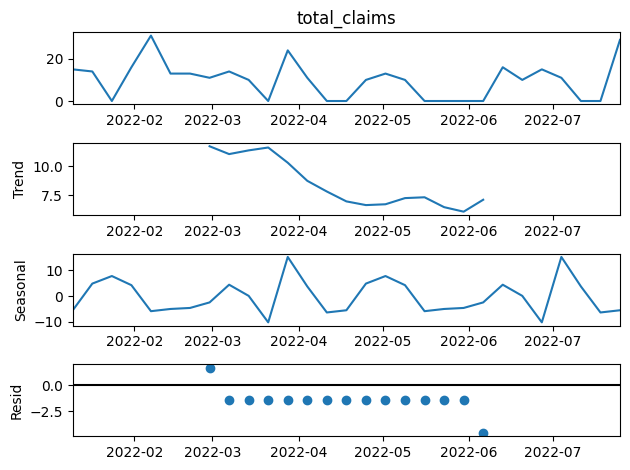

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

The time difference between the two minimums is 98 days 00:00:00


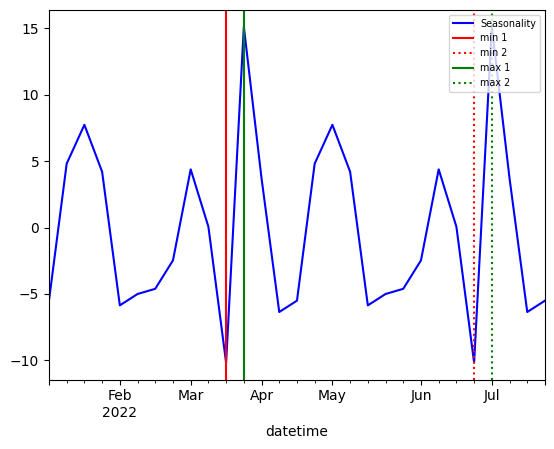

In [86]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

datetime
2022-01-10    15
2022-01-17    14
2022-01-24     0
2022-01-31    16
2022-02-07    31
2022-02-14    13
2022-02-21    13
2022-02-28    11
2022-03-07    14
2022-03-14    10
2022-03-21     0
2022-03-28    24
2022-04-04    11
2022-04-11     0
2022-04-18     0
2022-04-25    10
2022-05-02    13
2022-05-09    10
2022-05-16     0
2022-05-23     0
2022-05-30     0
2022-06-06     0
2022-06-13    16
2022-06-20    10
2022-06-27    15
2022-07-04    11
2022-07-11     0
2022-07-18     0
2022-07-25    29
Freq: W-MON, Name: total_claims, dtype: Int64


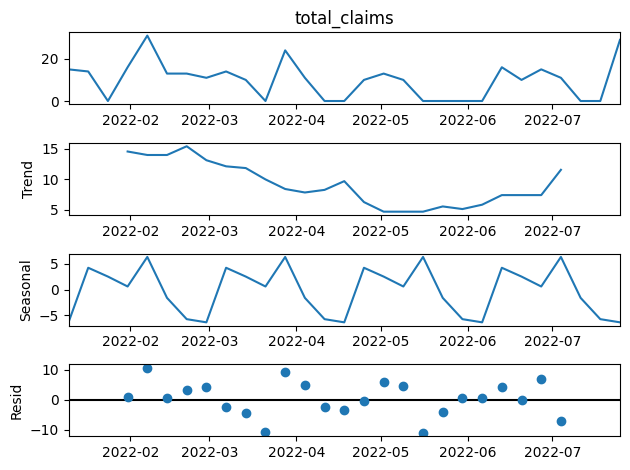

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(data_train["total_claims"].fillna(0))

The time difference between the two minimums is 49 days 00:00:00


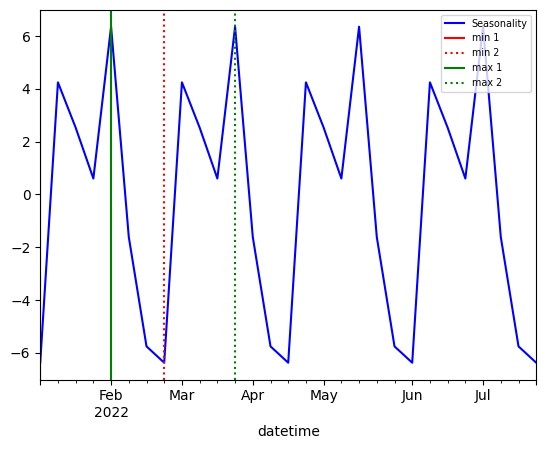

In [88]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

29


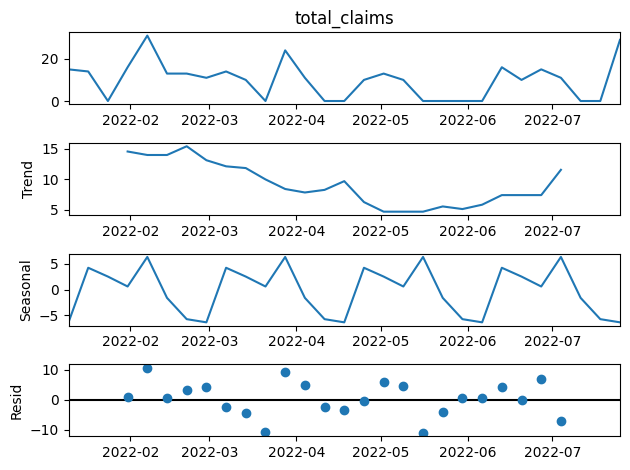

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

29


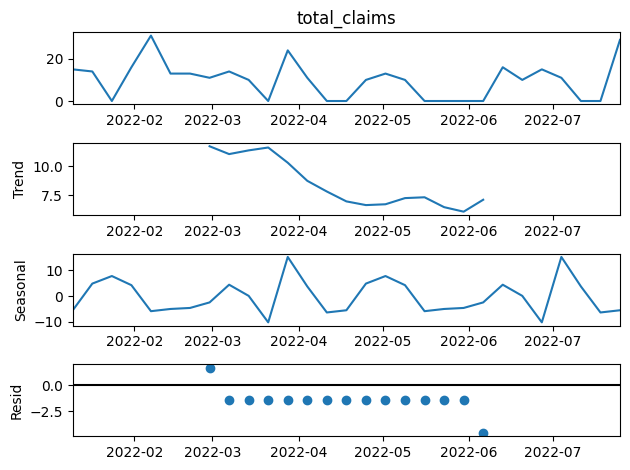

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

The time difference between the two minimums is 98 days 00:00:00


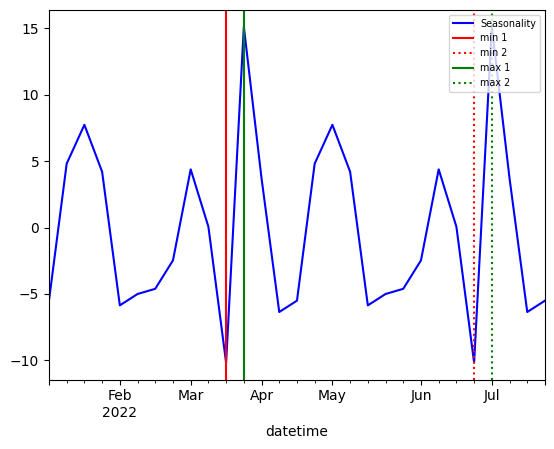

In [91]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

In [92]:
def sarimax_forecast(SARIMAX_model, periods=10,plot=0):
    # Forecast
    n_periods = periods

    forecast_df = data[data.index>=data_train.index[-1]]
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True)
    #print(confint)
    index_of_fc = pd.date_range(data_train.index[-1], periods = n_periods, freq='W-MON')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    # Plot
    if plot:
        plt.figure(figsize=(15,7))
        plt.plot(data["total_claims"], color='#1f76b4')
        plt.plot(fitted_series, color='darkgreen')
        plt.fill_between(lower_series.index, 
                        lower_series, 
                        upper_series, 
                        color='k', alpha=.15)

        plt.title("SARIMAX")
        plt.show()
    return fitted_series

In [93]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,m=14,maxiter=200)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32


f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


ValueError: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.

In [94]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),alpha=0.05,m=14)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32


f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


ValueError: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.

In [95]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=12, max_order=None,
                           trace=True)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=265.290, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=265.029, Time=0.03 sec


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=263.547, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=266.720, Time=0.02 sec


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=266.979, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=263.952, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.392 seconds
6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=217.828, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=216.979, Time=0.03 sec


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=215.848, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=219.121, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=219.133, Time=0.02 sec


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=221.121, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=215.808, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=216.986, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=218.978, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=210.961, Time=0.01 sec


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=212.909, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=212.909, Time=0.03 sec


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=205.512, Time=0.02 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=206.954, Time=0.04 sec


 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=207.157, Time=0.03 sec
 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=208.313, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=207.488, Time=0.02 sec


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=207.484, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec


 ARIMA(4,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=205.146, Time=0.01 sec
 ARIMA(3,1,0)(1,0,0)[12]             : AIC=206.317, Time=0.03 sec
 ARIMA(3,1,0)(0,0,1)[12]             : AIC=206.578, Time=0.02 sec


 ARIMA(3,1,0)(1,0,1)[12]             : AIC=207.832, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=209.576, Time=0.01 sec
 ARIMA(4,1,0)(0,0,0)[12]             : AIC=206.849, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[12]             : AIC=206.889, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=208.321, Time=0.01 sec
 ARIMA(4,1,1)(0,0,0)[12]             : AIC=208.817, Time=0.03 sec

Best model:  ARIMA(3,1,0)(0,0,0)[12]          
Total fit time: 1.017 seconds
b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=324.283, Time=0.00 sec


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=328.243, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=328.228, Time=0.06 sec


 ARIMA(0,0,0)(0,0,0)[12]             : AIC=347.945, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=326.282, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=326.282, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=328.282, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=326.243, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=326.229, Time=0.02 sec


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=327.968, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.261 seconds
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=175.692, Time=0.00 sec


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=179.164, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=179.176, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=180.083, Time=0.00 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=177.635, Time=0.03 sec


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=177.635, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=179.635, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=177.190, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=177.205, Time=0.02 sec


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=179.187, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.300 seconds
44585653fcc97ff048845c7718889631 37 27.954545454545453 11 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=260.066, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=261.718, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=262.113, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=310.249, Time=0.00 sec


 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=259.727, Time=0.04 sec


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=261.312, Time=0.16 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=261.312, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=260.160, Time=0.02 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=263.312, Time=0.06 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=261.716, Time=0.03 sec


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=263.682, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12]             : AIC=294.719, Time=0.01 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 0.545 seconds
1400fd6122c6fe7582a30ee1280beb4b 37 22.0977028802914 15 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=265.709, Time=0.00 sec


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=268.738, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=269.066, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=287.884, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=267.385, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=267.465, Time=0.03 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=267.378, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=267.477, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=266.389, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.320 seconds
0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=272.643, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=275.910, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=275.886, Time=0.04 sec


 ARIMA(0,0,0)(0,0,0)[12]             : AIC=314.948, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=274.643, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=274.643, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=276.643, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=274.042, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=273.985, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=275.894, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.280 seconds
eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=262.953, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=256.636, Time=0.06 sec


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=259.569, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=311.815, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=264.583, Time=0.03 sec


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=255.235, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=259.570, Time=0.03 sec


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.17 sec


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=256.668, Time=0.14 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,0)(1,0,1)[12] intercept
Total fit time: 1.670 seconds
124fe6d04692c372ffc4f84fc99f480d 37 20.389083308468027 13 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=279.057, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=277.621, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=277.065, Time=0.00 sec


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=279.805, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=279.447, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=281.375, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=276.289, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=277.563, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=279.553, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=275.805, Time=0.02 sec


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=276.646, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=276.615, Time=0.03 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=278.610, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=276.942, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=273.910, Time=0.01 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=274.807, Time=0.02 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=274.750, Time=0.02 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=276.750, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=274.330, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=275.051, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=272.753, Time=0.01 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=274.120, Time=0.04 sec
 ARIMA(2,1,1)(0,0,1)[12]             : AIC=273.828, Time=0.04 sec


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=270.753, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=272.148, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=271.905, Time=0.03 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=269.884, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=271.303, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=271.172, Time=0.02 sec


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=270.810, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=272.753, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 1.238 seconds
dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=275.611, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=273.127, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=273.671, Time=0.01 sec


 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=271.280, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=273.179, Time=0.04 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=271.950, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=269.384, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=271.236, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12]             : AIC=271.286, Time=0.02 sec


 ARIMA(1,1,0)(1,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=270.105, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=263.950, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=265.833, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=265.869, Time=0.02 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=262.184, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=263.933, Time=0.02 sec


 ARIMA(0,1,1)(0,0,1)[12]             : AIC=264.005, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=263.937, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=265.937, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 0.925 seconds
8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=246.320, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=248.720, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=248.865, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=256.623, Time=0.00 sec


 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=247.659, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=247.687, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=249.418, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=247.911, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=247.935, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=249.740, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.304 seconds
1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=264.191, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=267.369, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=267.392, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=285.346, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=266.026, Time=0.03 sec


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=266.006, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=265.705, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=265.752, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=267.695, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.349 seconds
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=296.085, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=298.621, Time=0.05 sec


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=298.660, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=334.767, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=296.754, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=296.814, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=298.714, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=298.045, Time=0.01 sec


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=298.040, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=299.935, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.349 seconds
b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=256.093, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=256.452, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=256.641, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=291.157, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=257.302, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=257.046, Time=0.04 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=254.888, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=256.403, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=256.778, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=256.356, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=255.168, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=258.316, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=264.720, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.496 seconds
3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=270.838, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=272.451, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=272.883, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=292.132, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=271.243, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=271.427, Time=0.03 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=272.317, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=272.480, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=272.670, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.320 seconds
5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=225.104, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=223.720, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=223.107, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=226.701, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=226.502, Time=0.02 sec


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=222.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=223.499, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=220.515, Time=0.01 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=222.099, Time=0.03 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=221.855, Time=0.03 sec


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=219.820, Time=0.02 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=221.397, Time=0.04 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=221.090, Time=0.04 sec


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=215.962, Time=0.03 sec
 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=217.411, Time=0.05 sec
 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=216.746, Time=0.04 sec


 ARIMA(4,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[12] intercept   : AIC=214.348, Time=0.03 sec
 ARIMA(5,1,0)(1,0,0)[12] intercept   : AIC=213.318, Time=0.07 sec


 ARIMA(5,1,0)(2,0,0)[12] intercept   : AIC=212.847, Time=0.16 sec


 ARIMA(5,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=0.88 sec


 ARIMA(5,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(5,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec


 ARIMA(5,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(4,1,0)(2,0,0)[12] intercept   : AIC=214.778, Time=0.12 sec


 ARIMA(5,1,1)(2,0,0)[12] intercept   : AIC=208.671, Time=0.41 sec
 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=214.334, Time=0.14 sec


 ARIMA(5,1,1)(3,0,0)[12] intercept   : AIC=209.651, Time=0.95 sec


 ARIMA(5,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec


 ARIMA(5,1,1)(3,0,1)[12] intercept   : AIC=211.764, Time=1.08 sec
 ARIMA(4,1,1)(2,0,0)[12] intercept   : AIC=215.109, Time=0.13 sec


 ARIMA(5,1,2)(2,0,0)[12] intercept   : AIC=217.635, Time=0.41 sec


 ARIMA(4,1,2)(2,0,0)[12] intercept   : AIC=215.487, Time=0.32 sec


 ARIMA(5,1,1)(2,0,0)[12]             : AIC=211.614, Time=0.30 sec

Best model:  ARIMA(5,1,1)(2,0,0)[12] intercept
Total fit time: 8.058 seconds
6b22ecccaddde4516a88c6981373daf3 37 10.64539771626749 25 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=278.531, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=277.982, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=276.536, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=280.531, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=280.531, Time=0.01 sec


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=276.187, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=278.060, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=270.230, Time=0.02 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=271.932, Time=0.04 sec


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=272.040, Time=0.04 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=270.614, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=268.306, Time=0.01 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=269.997, Time=0.02 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=270.109, Time=0.02 sec


 ARIMA(2,1,0)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=274.210, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=268.699, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=266.031, Time=0.01 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=267.962, Time=0.04 sec
 ARIMA(2,1,1)(0,0,1)[12]             : AIC=267.985, Time=0.03 sec
 ARIMA(2,1,1)(1,0,1)[12]             : AIC=inf, Time=0.11 sec


 ARIMA(1,1,1)(0,0,0)[12]             : AIC=265.467, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=267.344, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=267.384, Time=0.02 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=263.688, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=265.499, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=265.558, Time=0.02 sec


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=265.282, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=265.634, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 1.414 seconds
94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=303.926, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=306.490, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=306.809, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=321.889, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=305.443, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=305.418, Time=0.01 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=304.511, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=304.928, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=305.339, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.279 seconds
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=282.688, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=275.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=280.697, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=279.198, Time=0.01 sec


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=276.776, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=276.776, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=274.813, Time=0.03 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=276.776, Time=0.08 sec


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=278.776, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=277.308, Time=0.02 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=274.444, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=279.374, Time=0.01 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=276.443, Time=0.06 sec


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=276.443, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=274.819, Time=0.04 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=278.442, Time=0.11 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=266.095, Time=0.04 sec


 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=269.021, Time=0.02 sec
 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=267.981, Time=0.06 sec
 ARIMA(3,1,0)(0,0,2)[12] intercept   : AIC=268.013, Time=0.09 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=265.983, Time=0.05 sec


 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=267.981, Time=0.13 sec


 ARIMA(3,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=264.771, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=267.264, Time=0.03 sec


 ARIMA(4,1,0)(2,0,0)[12] intercept   : AIC=266.744, Time=0.16 sec
 ARIMA(4,1,0)(1,0,1)[12] intercept   : AIC=266.741, Time=0.12 sec
 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=265.023, Time=0.06 sec


 ARIMA(4,1,0)(2,0,1)[12] intercept   : AIC=268.734, Time=0.34 sec
 ARIMA(5,1,0)(1,0,0)[12] intercept   : AIC=266.568, Time=0.08 sec


 ARIMA(4,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec


 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(4,1,0)(1,0,0)[12]             : AIC=263.599, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[12]             : AIC=265.743, Time=0.02 sec
 ARIMA(4,1,0)(2,0,0)[12]             : AIC=265.578, Time=0.10 sec


 ARIMA(4,1,0)(1,0,1)[12]             : AIC=265.574, Time=0.08 sec
 ARIMA(4,1,0)(0,0,1)[12]             : AIC=263.811, Time=0.04 sec


 ARIMA(4,1,0)(2,0,1)[12]             : AIC=267.551, Time=0.34 sec
 ARIMA(3,1,0)(1,0,0)[12]             : AIC=264.376, Time=0.04 sec
 ARIMA(5,1,0)(1,0,0)[12]             : AIC=265.545, Time=0.05 sec
 ARIMA(4,1,1)(1,0,0)[12]             : AIC=264.557, Time=0.06 sec
 ARIMA(3,1,1)(1,0,0)[12]             : AIC=262.571, Time=0.04 sec


 ARIMA(3,1,1)(0,0,0)[12]             : AIC=264.572, Time=0.02 sec
 ARIMA(3,1,1)(2,0,0)[12]             : AIC=264.569, Time=0.10 sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=264.568, Time=0.07 sec


 ARIMA(3,1,1)(0,0,1)[12]             : AIC=262.706, Time=0.04 sec
 ARIMA(3,1,1)(2,0,1)[12]             : AIC=266.570, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[12]             : AIC=265.541, Time=0.04 sec


 ARIMA(3,1,2)(1,0,0)[12]             : AIC=264.562, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=272.967, Time=0.02 sec
 ARIMA(2,1,2)(1,0,0)[12]             : AIC=263.763, Time=0.06 sec
 ARIMA(4,1,2)(1,0,0)[12]             : AIC=266.564, Time=0.07 sec

Best model:  ARIMA(3,1,1)(1,0,0)[12]          
Total fit time: 4.278 seconds
ce64452a172b006bd45b3c1f147c88c1 37 16.957979446695294 13 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=256.583, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=254.986, Time=0.05 sec


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=255.559, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=285.241, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=255.903, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=256.937, Time=0.15 sec


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=256.937, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=255.367, Time=0.03 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=258.937, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=253.512, Time=0.03 sec


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=255.507, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=255.507, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=253.852, Time=0.02 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=257.507, Time=0.06 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=255.180, Time=0.03 sec


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=255.616, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12]             : AIC=282.782, Time=0.01 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 0.779 seconds
2d19305e3ee06c83f1247ddda5c70d57 37 23.60956619543306 10 -- 32
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=264.512, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=268.162, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=268.198, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=294.271, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=266.353, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=266.344, Time=0.02 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=266.254, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=266.308, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=267.937, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.317 seconds
c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=247.257, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=245.197, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=244.554, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=259.466, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=242.763, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=244.556, Time=0.03 sec


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=246.554, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=245.394, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=242.712, Time=0.02 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=244.519, Time=0.04 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=244.499, Time=0.03 sec


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=246.445, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=243.784, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=242.216, Time=0.02 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=244.071, Time=0.04 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=244.077, Time=0.05 sec


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=246.059, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=244.125, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[12] intercept   : AIC=244.039, Time=0.03 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=246.034, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[12]             : AIC=246.062, Time=0.01 sec

Best model:  ARIMA(0,0,3)(0,0,0)[12] intercept
Total fit time: 0.756 seconds
2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=172.026, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=173.966, Time=0.04 sec


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=173.950, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=180.341, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=171.997, Time=0.02 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=173.997, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=173.997, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=171.997, Time=0.01 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=175.997, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=173.946, Time=0.04 sec


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=175.831, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12]             : AIC=182.238, Time=0.01 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 0.330 seconds
69274b987d26fbed84eb7d2b157badb6 36 4.248306305668297 19 -- 24
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=282.803, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=285.546, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=285.414, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=312.425, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=284.439, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=284.472, Time=0.06 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=286.044, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=284.151, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=284.031, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=286.010, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.357 seconds
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=265.723, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=247.696, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=243.935, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=263.805, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=242.338, Time=0.03 sec


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=241.119, Time=0.07 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=243.119, Time=0.20 sec


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=243.119, Time=0.08 sec


 ARIMA(0,1,1)(3,0,1)[12] intercept   : AIC=245.119, Time=0.25 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=241.979, Time=0.06 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=242.102, Time=0.07 sec


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=244.275, Time=0.05 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=243.825, Time=0.11 sec
 ARIMA(0,1,1)(2,0,0)[12]             : AIC=240.118, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=241.655, Time=0.02 sec


 ARIMA(0,1,1)(3,0,0)[12]             : AIC=242.118, Time=0.27 sec
 ARIMA(0,1,1)(2,0,1)[12]             : AIC=242.118, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.08 sec


 ARIMA(0,1,1)(3,0,1)[12]             : AIC=244.118, Time=0.21 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(2,0,0)[12]             : AIC=240.868, Time=0.05 sec
 ARIMA(0,1,2)(2,0,0)[12]             : AIC=240.960, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=242.488, Time=0.04 sec


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=242.747, Time=0.08 sec

Best model:  ARIMA(0,1,1)(2,0,0)[12]          
Total fit time: 2.281 seconds
68153b89651358b0e4dab495d4feb3e9 37 8.778603394077425 16 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=288.609, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=290.232, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=290.766, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=333.661, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=289.549, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=289.492, Time=0.02 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=288.379, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=290.209, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=287.883, Time=0.02 sec


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=289.457, Time=0.05 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=289.432, Time=0.04 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=288.302, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=288.254, Time=0.03 sec


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=289.471, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=290.302, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=293.587, Time=0.01 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 0.745 seconds
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=295.629, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=298.522, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=298.658, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=351.647, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=296.923, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=297.005, Time=0.04 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=298.646, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=296.912, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=297.005, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=298.827, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.375 seconds
6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=218.664, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=222.641, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=222.633, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=242.259, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=220.664, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=220.664, Time=0.02 sec


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=222.664, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=220.642, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=220.635, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=222.656, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.234 seconds
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=250.866, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=246.945, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=247.613, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=271.712, Time=0.00 sec


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=247.602, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=248.856, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=248.855, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=246.943, Time=0.03 sec


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=248.856, Time=0.06 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=250.856, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=250.965, Time=0.02 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=248.920, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=248.925, Time=0.04 sec


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=250.739, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=250.990, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,1)[12] intercept
Total fit time: 0.637 seconds
fe355ff27aa8b2242a558d5e3ec99c18 36 8.516809584270913 25 -- 33
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=266.891, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=265.472, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=262.716, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=289.162, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=262.677, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=263.665, Time=0.03 sec


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=263.943, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=264.417, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=266.618, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=273.376, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 0.353 seconds
f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=291.394, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=290.107, Time=0.05 sec


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=289.009, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=326.939, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=288.372, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=288.450, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=288.528, Time=0.14 sec


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=290.213, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=290.135, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=290.122, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=292.001, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=309.440, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 0.395 seconds
67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=278.136, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=277.318, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=276.210, Time=0.01 sec


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=279.702, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=279.778, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=277.644, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.335 seconds
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=255.762, Time=0.00 sec


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=258.769, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=258.198, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=309.930, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=257.272, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=257.016, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=257.573, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=257.562, Time=0.01 sec


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=259.556, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.273 seconds
3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=327.090, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=325.588, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=326.745, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=372.680, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=323.672, Time=0.01 sec


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=325.590, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=327.592, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=325.495, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=325.348, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=324.746, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=327.179, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=332.148, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.385 seconds
cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=222.482, Time=0.00 sec


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=218.738, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=219.939, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=228.986, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=217.150, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=218.603, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=220.397, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=219.146, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=219.140, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=218.003, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=221.100, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=218.796, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 0.295 seconds
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=184.025, Time=0.00 sec


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=178.095, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=182.032, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=176.751, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=177.906, Time=0.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=174.876, Time=0.01 sec


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=175.021, Time=0.05 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=175.873, Time=0.02 sec


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=173.415, Time=0.01 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=173.779, Time=0.02 sec
 ARIMA(2,1,0)(0,0,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=174.846, Time=0.00 sec
 ARIMA(3,1,0)(0,0,0)[12]             : AIC=174.765, Time=0.01 sec


 ARIMA(2,1,1)(0,0,0)[12]             : AIC=174.346, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=172.643, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=173.512, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=173.278, Time=0.02 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=171.816, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=172.221, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=172.039, Time=0.02 sec


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=172.071, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=173.740, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 1.067 seconds
da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25


ValueError: zero-size array to reduction operation maximum which has no identity

In [96]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=12, max_order=None)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 27.954545454545453 11 -- 34


1400fd6122c6fe7582a30ee1280beb4b 37 22.0977028802914 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34


eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34


124fe6d04692c372ffc4f84fc99f480d 37 20.389083308468027 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34


1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33


a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34


3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 10.64539771626749 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34


ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.957979446695294 13 -- 34


2d19305e3ee06c83f1247ddda5c70d57 37 23.60956619543306 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34


69274b987d26fbed84eb7d2b157badb6 36 4.248306305668297 19 -- 24


4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 8.778603394077425 16 -- 34


42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 8.516809584270913 25 -- 33


f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34


8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34


3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34


a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25


ValueError: zero-size array to reduction operation maximum which has no identity

In [97]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=None, max_order=None)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [98]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5,  max_order=None)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34
44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34
1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34
eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34
124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34
8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34


1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34
b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34


3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34
5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34
2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32
c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34
69274b987d26fbed84eb7d2b157badb6 36 5.875000000000002 19 -- 24
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34
1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31
fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33


f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34
67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34


3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34
cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34


a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25
074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27
48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34


97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34
3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34
627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34
939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 23.500322580801885 13 -- 34
8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34
6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34
fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34
931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34
32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34


4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 31.362224246193605 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34
15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31
46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34
89ca758dd8e4958d6e8e32ccb439c638 37 17.999999999999996 33 -- 33
4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31
7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34
7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34


94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34
348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34


e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34
0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34
50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34
447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34
8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34


abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33
25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34
4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34
d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34
b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34
bbcb018f0e5e49e13636f6e78ce9f60f 37 24.676470588235297 13 -- 34


52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34
3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34
63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34
2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34
953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 14.83812355811203 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34
f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34
663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34
50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25
4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31
dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34
f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34
19c0ba2728a6971ff9c1301f3bf17f59 37 10.0 16 -- 26


In [99]:
pred_df = pd.DataFrame()
uuid_list = []
week_number_list = []
total_claims_list = []
#stat=[]
for l in output:
    uuid_list.append(l[0])
    week_number_list.append(l[1])
    if l[2]<0:
        l[2] = 0
    total_claims_list.append(int(np.floor(l[2])))
    #stat.append(l[1])
pred_df["uu_id"] = uuid_list
pred_df["week_number"] = week_number_list
pred_df["total_claims"] = total_claims_list
#pred_df["stationarity"] = stat

In [100]:
pred = []
actual = []
pred_stat = []
actual_stat = []
pred_nonstat = []
actual_nonstat = []
ts_data = merged_data
for id,row in pred_df.iterrows():
    uuid = row["uu_id"]
    week_number = row["week_number"]
    if len(ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"])==0:
        continue
    actual_val = ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"].item()
    pred.append(row["total_claims"])
    actual.append(actual_val)

In [101]:
loss(pred=pred,actual=actual)        

Mean Absolute Error: 12.95
Mean squared Error: 375.41
Accuracy: 52.48%.


In [102]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, m=7, max_order=None)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 -3.1100920999144153 12 -- 32


f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34


1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34


eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34


124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 9.643375505587148 17 -- 34


8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34


1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33


a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34


3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34


5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34


ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.060334746577183 13 -- 34


2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32


c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34


69274b987d26fbed84eb7d2b157badb6 36 5.219535905843578 19 -- 24


4da27496ea51392169807ce30edde6bf 37 18.67133649978632 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34


42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 47.138748413334696 27 -- 34


1fe978b588e12780393047c4294e4c8a 36 8.741935483870968 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 10.763825400684336 25 -- 33


f142e2854cb3408a0daf85c0d1f97e74 37 11.825823520681606 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34


8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34


3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 57.30300733953225 33 -- 34


a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25


074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27


48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34


97e5bdffc50e369922a89c3946a92e44 37 28.617647058823533 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34


3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34
2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34


939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 21.061277301194007 13 -- 34


8c9d2aa90948679972a9382aadcc6001 37 16.78044078706626 31 -- 34


6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34


fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31


8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34


931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34


32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34


4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 31.362224246193605 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34


15118b0768fba87d2ac7770249b5fb36 37 8.483870967741934 31 -- 31


46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34


89ca758dd8e4958d6e8e32ccb439c638 37 17.999999999999996 33 -- 33


4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 16.030779237370655 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31


7cf24c78c601ab6a16ab1607a5426d29 37 11.940074400014524 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 28.71853235919552 21 -- 34


94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34


348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34


e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34


0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34


50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34


447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34


8dad735d80cf4a1768bbf15c68e3afa7 37 10.558823529411766 23 -- 34
abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33


25f9cfb8488ebf12f28e2bf44754984d 37 22.088235294117645 10 -- 34


4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34


d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34


b5dd82a5d296b283ded47e0110ce386d 37 20.11764705882353 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 24.676470588235297 13 -- 34


52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34


63b65e67206ef8201d3df16a8fc518b7 37 21.0 22 -- 34


2686710e45843273cb902096aee8d8ab 37 18.76529521623352 14 -- 34


953e68b130eaa59a171dc28d594d5303 37 7.734193334111646 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 14.83812355811203 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30


db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34


f328006c7c2a699678d33c97ed0b5dde 37 13.008849721385868 82 -- 34


663b0660c9f85a475e5b7ce499dc48a3 37 20.65508449433273 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34


50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 1.7127994421906578 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34


f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33


8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 1.419490816529187 16 -- 26


In [103]:
exog = ['edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']
exog = ['edu_8th_or_less', 'edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown']
ids = merged_data["uu_id"].unique()[:]
output = []
for cnt,idd in enumerate(ids):
    if cnt > 100: break
    data = merged_data.loc[merged_data["uu_id"]==idd].copy()
    data = data.asfreq('W-MON')
    is_na = []
    for idx,row in data.iterrows():
        if pd.isna(row["total_claims"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data["is_na"] = is_na
    #data["total_claims"] = data["total_claims"].fillna(0)
    start_week = 0
    #print(data["week_number"].max())
    boundary_week = data["week_number"].max()-2
    data_train = data.loc[(data["week_number"]<boundary_week) & (data["week_number"]>start_week)].drop("is_na",axis=1)
    is_na = []
    for idx,row in data_train.iterrows():
        if pd.isna(row["week_number"]):
            #print(f'NA found in week {idx}')
            is_na.append(1)
        else:
            is_na.append(0)
    data_train["is_na"] = is_na
    data_train = data_train.asfreq('W-MON')
    SARIMAX_model = pm.auto_arima(data_train["total_claims"].fillna(0),start_p=0, start_q=0, max_p=5,
                           max_q=5, start_P=0, start_Q=0, max_P=5,
                           max_Q=5, max_order=None,seasonal=False)
    max_week_no = data["week_number"].max()
    pred_periods =  max_week_no - data_train["week_number"].max()
    #SARIMAX_model_fit = SARIMAX_model.fit(data_train["total_claims"].fillna(0))
    #check_st = check_stationary(data_train["total_claims"].fillna(0),1)
    prediction = sarimax_forecast(SARIMAX_model, periods=int(pred_periods)+1,plot=0)
    out = prediction.loc[prediction.index[-1]]
    #print(prediction)
    #print(prediction.loc[prediction.index[-1]])
    output.append([idd,max_week_no,out])
    #print(check_stationary(data_train["total_claims"].fillna(method="bfill"),1))
    if len(data.loc[data["week_number"]==max_week_no,"total_claims"])>0:
        print(idd,max_week_no,out,data.loc[data["week_number"]==max_week_no,"total_claims"].item(),"--",len(data_train.index))
    else:
        print(idd,max_week_no,out,"--",len(data_train.index))
    #break

6c316cb2fc150a2f9fd50925926fc1f8 37 11.999999999999998 19 -- 34


b57c8824284adeabf73b43cf206b3819 37 3.651505467722322 12 -- 32
f38aacf279329cbb0fd7807a9ddc6f6c 37 28.52941176470588 15 -- 34


44585653fcc97ff048845c7718889631 37 15.348271460118061 11 -- 34


1400fd6122c6fe7582a30ee1280beb4b 37 19.941176470588236 15 -- 34


0eadc4f22396980ecc2e7878ffbaf14a 37 11.558823529411766 28 -- 34


eccf545fec3a624430ee4b264e4d7c3e 37 20.58823529411765 11 -- 34


124fe6d04692c372ffc4f84fc99f480d 37 20.294117647058822 13 -- 34


dc370d6cb5c3688ac7fa00f9ee56b4bd 37 10.220887534734453 17 -- 34
8932b66a9b94dcf03c942facc50ff401 37 19.62854507503343 23 -- 34


1a37add233259107b266614f22bffd9b 36 6.393939393939391 35 -- 33
a04177f6fbc3ba8065f2681089a0fad7 37 10.97058823529412 12 -- 34


b249b93771413c68f826e6583566f645 37 26.970588235294123 22 -- 34


3193b3205553224c47be06622d7b044d 37 14.019226297932201 37 -- 34
5c43cbf8f0d860e91a9160706ea9b7d8 37 12.147058823529413 11 -- 34


6b22ecccaddde4516a88c6981373daf3 37 1.5292270401498471 25 -- 34


94f1f3cc229ef12ee0659de4ab3b4e94 37 15.959562891592876 10 -- 34
ce8723e47ce346b09bc20deb5d27749e 36 20.75757575757575 14 -- 33


ce64452a172b006bd45b3c1f147c88c1 37 16.21406185011298 13 -- 34


2d19305e3ee06c83f1247ddda5c70d57 37 18.185351948340582 10 -- 32
c54e262cc40c41b9095dcb5e08ce6e71 37 15.939393939393932 13 -- 33


2420ca4ef50459c0bcc8fdeb8ee35a68 37 5.589409184289327 45 -- 34


69274b987d26fbed84eb7d2b157badb6 36 1.8033656834320964 19 -- 24
4da27496ea51392169807ce30edde6bf 37 18.08823529411765 24 -- 34


68153b89651358b0e4dab495d4feb3e9 37 9.90077531750634 16 -- 34
42dec75b5a3b02de7908789cc6649e6d 37 27.568622009897936 40 -- 34


6877b5946ab2ee471e4c546252057f29 37 37.44117647058824 27 -- 34


1fe978b588e12780393047c4294e4c8a 36 7.645377204073773 17 -- 31


fe355ff27aa8b2242a558d5e3ec99c18 36 9.514596460483892 25 -- 33


f142e2854cb3408a0daf85c0d1f97e74 37 4.927155372606054 60 -- 34


67bbd99237964244c2ad3d0531394291 37 23.497289289555145 15 -- 34
8eef3f1453830d1939aae4e774e87c53 37 12.0 18 -- 34


3eaeeb015822cc1c6b77c914fae0d087 37 20.147058823529417 15 -- 34


cb304c84e572423d939db1dbb2009609 37 47.006858559037966 33 -- 34
a21252ae119bf94fb9343a9d279b1f09 37 5.6217322347191825 15 -- 34


da68e5b292b530606ce5e2f7d9fb4342 37 6.819336440621994 15 -- 25
074f501122885ab9aef5e9d07004209d 35 7.78887727204451 16 -- 27


48ac5846d8d781fd5b7c6a863a572359 37 16.7148414018451 67 -- 34


97e5bdffc50e369922a89c3946a92e44 37 27.66015070362711 59 -- 34


5db93f554d0a9df617e6e51043049dc4 37 15.623169263848274 17 -- 34


3c887b182d660a9a6b874c5f9b4f3f61 37 38.05882352941177 25 -- 34


627f0516c61e02f14a399ff99aaf141c 37 19.68830160811739 83 -- 34


2788f24947b2fc8fcc0ded4a4403d9ff 36 10.939393939393934 10 -- 33


5091d0be49e94dc89756d9b0dd743214 37 34.856411366900254 20 -- 34


939e1edba462129ca3442d7e80e3a6df 37 21.61764705882353 15 -- 34


a01b6cfa3022893470d884ca2534202c 37 23.500322580801885 13 -- 34


8c9d2aa90948679972a9382aadcc6001 37 14.911764705882353 31 -- 34


6a5609f385912113b6f1014b958ed748 34 18.580645161290317 20 -- 31
9dd9614f2619fd1b8397cabdb3f2248a 37 20.47058823529412 32 -- 34


fa339582e0e0e47497dbe039bb00b19f 36 12.677419354838708 18 -- 31
8267c703abd7db102110ec19c18ae372 37 8.235646071849306 14 -- 34


931e7312a52b294244e6e05d33134c1e 37 39.47058823529412 53 -- 34


32686c399e21429791a419c0146217c9 37 35.130388834021005 18 -- 34


4a22571b2563761671604973ba849ef5 37 25.882352941176478 19 -- 34


81594c0c7e4ef4c4cdbb7133d01cb361 37 31.362224246193605 14 -- 34


f4156396854199e5d45a23248e03e379 37 25.82455032276025 78 -- 34


15118b0768fba87d2ac7770249b5fb36 37 7.507160853741595 31 -- 31
46e96d9a3529a65f56d9e6a8dd33fc87 37 10.117647058823529 24 -- 34


4b64982fb643e7eee44ce1ef8929cb44 37 9.517443055867181 12 -- 34
89ca758dd8e4958d6e8e32ccb439c638 37 17.999999999999996 33 -- 33


4869240f378dd59f04a0a083c0fe6c03 37 31.960438382197168 17 -- 34


2835004b63bf80d6929a55a6d14842e1 37 15.158294508608204 28 -- 34


9a8d8797ae3765b4ca946803c38b8ea6 37 11.156127354071259 11 -- 31


7cf24c78c601ab6a16ab1607a5426d29 37 9.372464970058058 27 -- 34


7e2478517261a19d87c0ab2e737fb25f 37 21.85294117647059 21 -- 34


94cfe2eeb9088207be40c491c2b8524e 37 25.161978233612068 14 -- 34
348c852abba65f89cd8af9395d6069d8 37 5.1010888325007 32 -- 34


e99e2af4a924268f8dae0beba680b0bf 37 25.117647058823533 29 -- 34
0d165590afad07ce71727d690f4aad80 37 16.794117647058822 77 -- 34


50247c509e6c47b550a516f66e35c1d1 37 18.941176470588236 25 -- 34
447d5984bb8a8179bff002ccd1bba162 37 15.08823529411765 10 -- 34


8dad735d80cf4a1768bbf15c68e3afa7 37 17.495576134068404 23 -- 34


abd614b6bace46049b465469a384ac0b 37 7.212121212121209 11 -- 33


25f9cfb8488ebf12f28e2bf44754984d 37 21.111182391992685 10 -- 34


4258714000b9209afeb28e3032d8873d 37 19.294117647058826 30 -- 34
d1e34bb3edb270f7321788fd307f170e 36 28.06060606060605 23 -- 33


e8b3b95e93a6dc7dbb90f4e72e7ac065 36 2.2687827581029634 16 -- 33


46c92d587470f0bc73b7474ac0fd41ca 37 14.076412678886896 14 -- 34


b5dd82a5d296b283ded47e0110ce386d 37 18.185880222606958 25 -- 34


bbcb018f0e5e49e13636f6e78ce9f60f 37 24.039330677939873 13 -- 34


52f393e27a5d94231575ab9bfa341bcf 37 25.429098234532095 84 -- 34


3224483a60925de51923d51b10a00141 37 13.343750000000002 12 -- 32


4338a76c28b57d89da8a28cf06adcf73 37 12.082689474296298 13 -- 34


63b65e67206ef8201d3df16a8fc518b7 37 16.502477136694836 22 -- 34
2686710e45843273cb902096aee8d8ab 37 18.764705882352946 14 -- 34


953e68b130eaa59a171dc28d594d5303 37 8.647058823529413 11 -- 34


1baabe619d226c9e7f1ef756fb41432b 37 14.83812355811203 15 -- 34


cb09047c9bc2c7afd2d74daa905f68bf 36 5.256425379192492 30 -- 30
db0fbb4c6e88a74d6387efab221c1a7a 37 28.676470588235293 31 -- 34
f328006c7c2a699678d33c97ed0b5dde 37 15.081815161094692 82 -- 34


663b0660c9f85a475e5b7ce499dc48a3 37 23.411764705882355 15 -- 34


6e585a6e6fc9cd621d7f73b92c292214 37 25.617647058823533 36 -- 34


50088293eaca82f8c05e74c7aa38733f 31 16.082724809706974 11 -- 25


4c612ffd5f49d054536c369580b91474 37 28.794117647058826 26 -- 34


51a955afdcc0c4de1b57a881226925c0 36 7.068712835449597 30 -- 31
4f38233021d41195c29f0a206e75a77e 35 8.774193548387096 12 -- 31


dd012c5266c9843f1049d7d012b18ed0 37 13.558823529411766 19 -- 34


f6d5c6d9c9f4d5b9e178ba482f663970 37 31.205882352941174 29 -- 34


9883a286690ddb549fd39aff729f83ee 36 11.045282792791951 18 -- 33
8baa08eb0d7462333382e51f72737b14 37 8.588235294117647 32 -- 34


19c0ba2728a6971ff9c1301f3bf17f59 37 10.0 16 -- 26


In [104]:
pred_df = pd.DataFrame()
uuid_list = []
week_number_list = []
total_claims_list = []
#stat=[]
for l in output:
    uuid_list.append(l[0])
    week_number_list.append(l[1])
    if l[2]<0:
        l[2] = 0
    total_claims_list.append(int(np.floor(l[2])))
    #stat.append(l[1])
pred_df["uu_id"] = uuid_list
pred_df["week_number"] = week_number_list
pred_df["total_claims"] = total_claims_list
#pred_df["stationarity"] = stat

In [105]:
pred = []
actual = []
pred_stat = []
actual_stat = []
pred_nonstat = []
actual_nonstat = []
ts_data = merged_data
for id,row in pred_df.iterrows():
    uuid = row["uu_id"]
    week_number = row["week_number"]
    if len(ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"])==0:
        continue
    actual_val = ts_data.loc[(ts_data["uu_id"]==uuid) & (ts_data["week_number"] == week_number),"total_claims"].item()
    pred.append(row["total_claims"])
    actual.append(actual_val)

In [106]:
loss(pred=pred,actual=actual)        

Mean Absolute Error: 13.09
Mean squared Error: 384.57
Accuracy: 52.11%.


In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0).diff(),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: cannot convert to 'float64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].diff(),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: cannot convert to 'float64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].diff().fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 26 observation(s)

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].diff().diff().fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 26 observation(s)

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].diff().diff().diff().fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 26 observation(s)

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 26 observation(s)

In [113]:
ids = merged_data["uu_id"].unique()[:]
data = merged_data.loc[merged_data["uu_id"]==ids[500]].copy()
print(data["week_number"].max())
data_train = data[data["week_number"]<32]
#data_train = data_train.asfreq('W-MON')

37


In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 19 observation(s)

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"],period=14)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: x must have 2 complete cycles requires 28 observations. x only has 19 observation(s)

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"])
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [117]:
ids = merged_data["uu_id"].unique()[:]
data = merged_data.loc[merged_data["uu_id"]==ids[500]].copy()
print(data["week_number"].max())
data_train = data[data["week_number"]<32]
#data_train = data_train.asfreq('W-MON')

37


In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"])
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

19


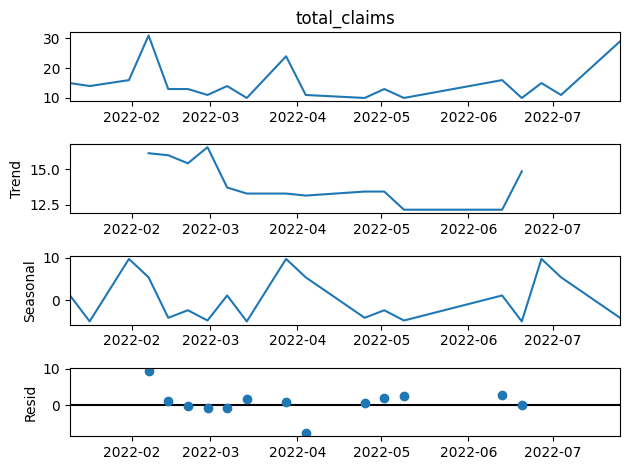

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"],period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

In [120]:
ids = merged_data["uu_id"].unique()[:]
data = merged_data.loc[merged_data["uu_id"]==ids[500]].copy()
print(data["week_number"].max())
data_train = data[data["week_number"]<32]
data_train = data_train.asfreq('W-MON')

37


29


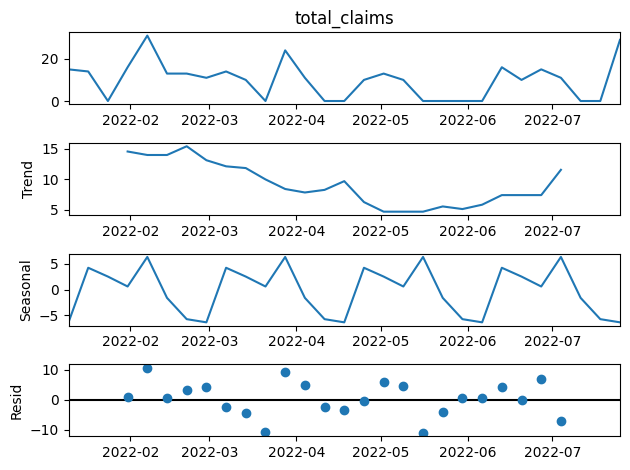

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Taking the decomposition
decomposition = seasonal_decompose(data_train["total_claims"].fillna(0),period=7)
# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
print(len(data_train["total_claims"].fillna(0)))

In [122]:
from sklearn.linear_model import LinearRegression

In [123]:
model = LinearRegression()
X = [i for i in range(len(data_train["total_claims"].fillna(0)))]
y = data_train["total_claims"].fillna(0)
model.fit(X,y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [124]:
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.plot(show)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

detrended = 

In [125]:
from sklearn.linear_model import LinearRegression

In [126]:
model = LinearRegression()
X = [i for i in range(0,len(data_train["total_claims"].fillna(0)))]
y = data_train["total_claims"].fillna(0)
model.fit(X,y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [127]:
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.plot(show)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

detrended = 

In [128]:
from sklearn.linear_model import LinearRegression

In [129]:
model = LinearRegression()
X = [i for i in range(0,len(data_train["total_claims"].fillna(0)))].reshape(-1,1)
y = data_train["total_claims"].fillna(0)
model.fit(X,y)

AttributeError: 'list' object has no attribute 'reshape'

In [130]:
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.plot(show)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

detrended = 

In [131]:
from sklearn.linear_model import LinearRegression

In [132]:
model = LinearRegression()
X = [i for i in range(0,len(data_train["total_claims"].fillna(0)))]
X = np.reshape(X,(len(X),1))
y = data_train["total_claims"].fillna(0)
model.fit(X,y)

LinearRegression()

NameError: name 'show' is not defined

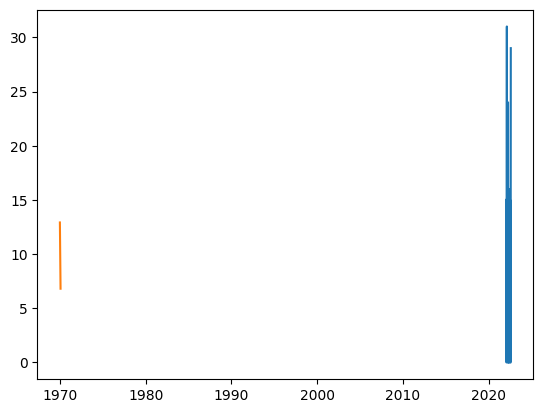

In [133]:
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.plot(show)

detrended = 

In [134]:
from sklearn.linear_model import LinearRegression

In [135]:
model = LinearRegression()
X = [i for i in range(0,len(data_train["total_claims"].fillna(0)))]
X = np.reshape(X,(len(X),1))
y = data_train["total_claims"].fillna(0)
model.fit(X,y)

LinearRegression()

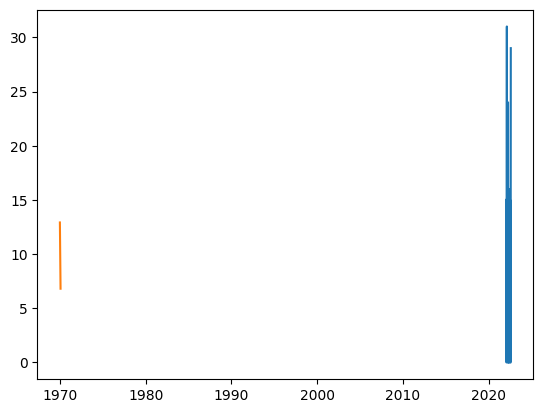

In [136]:
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()

detrended = 